In [1]:
import pandas as pd
from pathlib import Path
from xgboost import XGBClassifier, plot_importance
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Import plotnine for ggplot2 like plotting
from plotnine import ggplot, aes, facet_wrap, labs, theme, coord_flip
# Import plotnine geoms to plot
from plotnine import geom_point, geom_smooth, geom_boxplot, geom_histogram, geom_bar, geom_text, geom_col
# Formating
from plotnine import element_text, element_blank, element_line, scale_x_discrete, scale_x_continuous, scale_y_continuous, position_stack

from mizani.formatters import percent_format

In [2]:
PATH_DATA = Path("data")


# Modelación del problema

Para el presente problema se escoge una división del problema en dos etapas debido al desbalanceo de los datos para la predicción directa de un porcentaje de descuento:
1. **Modelo de clasificación de items para definir si aplica descuento (Variable objetivo: has_discount)**: Este modelo busca determinar si es adecuado o no ofrecer o no un descuento a un producto dado según sus características
2. **Modelo de predicción de tasa de descuento (Variable objetivo: discount_rate)**: Este modelo definira el porcentaje de descuento sugerido para un producto, teniendo unicamente en cuenta la data de los items que poseen un descuento.

In [3]:
model_data = pd.read_csv(PATH_DATA / 'preprocessed_model_data.csv')
model_data.head()

,price,available_quantity,accepts_mercadopago,catalog_listing,shipping_free_shipping,installments_quantity,transactions_total,discount_rate,has_discount,expiration_days,...,level_id_5_green,power_seller_status_gold,power_seller_status_platinum,power_seller_status_silver,user_type_branch,user_type_brand,user_type_car_dealer,user_type_franchise,user_type_normal,user_type_real_estate_agency
0,23309.0,1,1,1,0,36.0,5829,0.00000,0,6956,...,1,0,1,0,0,1,0,0,0,0
1,37427.0,1,1,1,0,36.0,5829,0.00000,0,7284,...,1,0,1,0,0,1,0,0,0,0
2,19159.0,250,1,1,0,1.0,2343,0.00000,0,6822,...,1,0,0,0,0,0,0,0,1,0
3,1629900.0,150,1,1,1,12.0,22299,0.09445,1,7037,...,1,0,1,0,0,1,0,0,0,0
4,605000.0,1,1,1,1,36.0,812,0.00000,0,6639,...,1,1,0,0,0,0,0,0,1,0


In [4]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114651 entries, 0 to 114650
Data columns (total 75 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   price                                 114651 non-null  float64
 1   available_quantity                    114651 non-null  int64  
 2   accepts_mercadopago                   114651 non-null  int64  
 3   catalog_listing                       114651 non-null  int64  
 4   shipping_free_shipping                114651 non-null  int64  
 5   installments_quantity                 114651 non-null  float64
 6   transactions_total                    114651 non-null  int64  
 7   discount_rate                         114651 non-null  float64
 8   has_discount                          114651 non-null  int64  
 9   expiration_days                       114651 non-null  int64  
 10  condition_new                         114651 non-null  int64  
 11  

## 1.1 Modelo de clasificación de items para definir si aplica descuento

### 1.1.1 División de features

Usaremos *has_discount* como variable objetivo y todas las demás como las utilizaremos como features para la predicción, a excepción de la variable *discount_rate*. Esto debido a que *has_discount* surge de la variable *discount_rate*, con lo cuál le estaríamos brindando erroneamente al modelo una pista respecto a sus variables predictoras.

In [5]:
X = model_data.drop(['has_discount', "discount_rate"], axis=1)
y = model_data["has_discount"]

### 1.1.2 Balanceo de clases

Vemos que existe un desbalanceo elevado en las clases de *has_discount*

In [6]:
model_data["has_discount"].value_counts(normalize=True)

has_discount
0    0.782488
1    0.217512
Name: proportion, dtype: float64

Para solucionar esta situación se opta por realizar un undersampling sobre el dataset para igual las clases

In [7]:
undersample = RandomUnderSampler(sampling_strategy = "majority", random_state=42) 
x_under, y_under = undersample.fit_resample(X, y) 

In [8]:
print(y_under.shape)
y_under.value_counts(normalize=True)

(49876,)


has_discount
0    0.5
1    0.5
Name: proportion, dtype: float64

### 1.1.3 División de datos train-test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x_under, y_under, test_size=0.2, random_state=42)

### 1.1.3 Generación del modelo XGBoost Classifier

In [10]:
class_model_xgb = XGBClassifier()
class_model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [11]:
y_pred_xgb = class_model_xgb.predict(X_test)

#### 1.1.3.1 Métricas iniciales

In [12]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      4955
           1       0.79      0.81      0.80      5021

    accuracy                           0.80      9976
   macro avg       0.80      0.80      0.80      9976
weighted avg       0.80      0.80      0.80      9976



In [13]:
print("El AUC score es de " + str(roc_auc_score(y_test, y_pred_xgb)))

El AUC score es de 0.796318248422217


#### 1.1.3.2 Feature importance

In [14]:
feature_importance_scores = pd.DataFrame([class_model_xgb.get_booster().get_score(importance_type='gain')]).T.reset_index()
feature_importance_scores.rename(columns={"index": "feature", 0: "importance"}, inplace=True)
feature_importance_scores = feature_importance_scores.sort_values(by = "importance", ascending = False)
feature_importance_scores["relative_importance"] = (feature_importance_scores['importance'] / feature_importance_scores['importance'].sum())
feature_importance_scores.shape

(57, 3)

In [15]:
feature_importance_scores.head(10)

,feature,importance,relative_importance
7,condition_new,241.184311,0.239029
50,level_id_5_green,67.607750,0.067004
14,shipping_logistic_type_fulfillment,64.582230,0.064005
25,category_MCO118204,63.317307,0.062751
43,category_MCO3025,34.659515,0.034350
54,user_type_brand,32.426620,0.032137
23,category_MCO1168,30.521320,0.030249
22,category_MCO1144,23.454317,0.023245
42,category_MCO1953,22.758421,0.022555
24,category_MCO1182,20.969059,0.020782


Vemos que de manera general, variables como *condition_new*, *level_id*, *shipping_logistic_type*, *category* y *user_type* son las variables que explican principalmente el modelo.

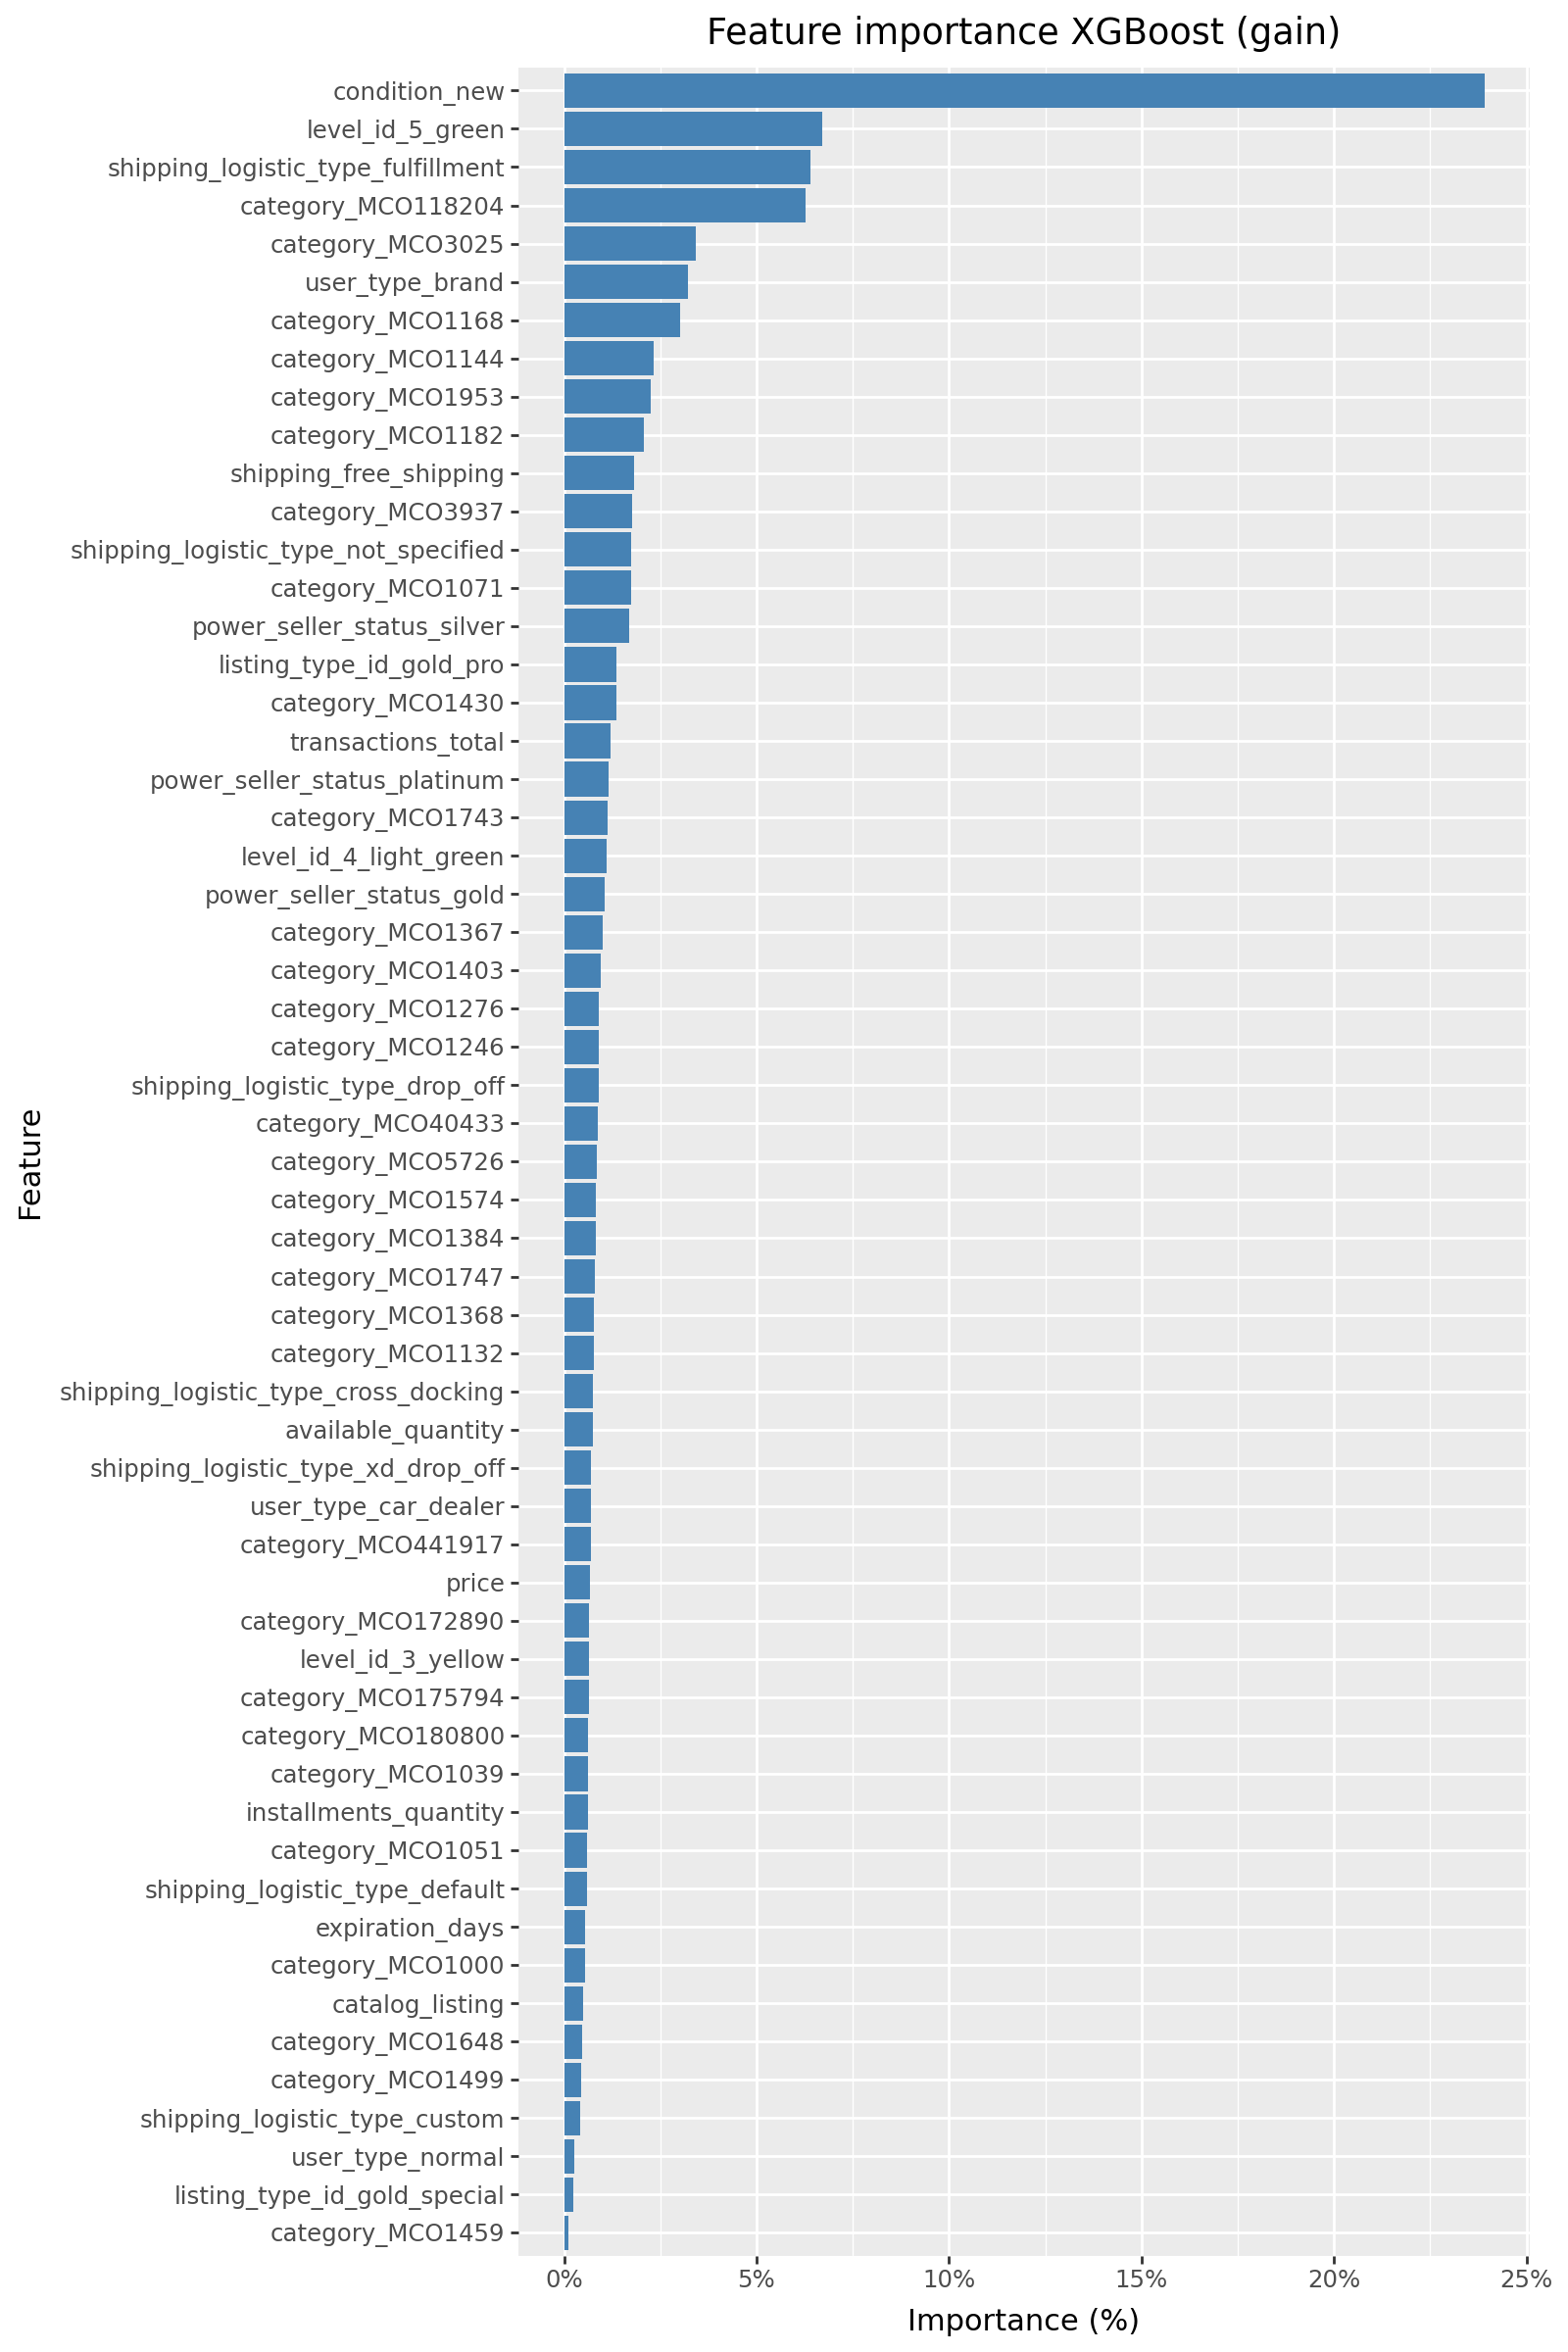

In [16]:
feature_order = feature_importance_scores["feature"].tolist()

(ggplot(feature_importance_scores, aes(x='feature', y='relative_importance')) +
 geom_bar(stat='identity', fill='steelblue') +
 theme(legend_position="none", figure_size=(8, 12)) + 
 labs(title="Feature importance XGBoost (gain)", x="Feature", y="Importance (%)") + 
 scale_y_continuous(labels = percent_format()) +
 scale_x_discrete(limits = feature_order[::-1]) +
 coord_flip()
)

### 1.1.4 Generación del modelo support vector machines (SVM)

In [17]:
class_model_svm = SVC()
class_model_svm.fit(X_train, y_train)

SVC()

In [18]:
y_pred_svm = class_model_svm.predict(X_test)

#### 1.1.4.1 Métricas iniciales

In [19]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.08      0.15      4955
           1       0.52      1.00      0.69      5021

    accuracy                           0.54      9976
   macro avg       0.76      0.54      0.42      9976
weighted avg       0.75      0.54      0.42      9976



In [20]:
print("El AUC score es de " + str(roc_auc_score(y_test, y_pred_svm)))

El AUC score es de 0.5413803096620833
